In [1]:
import glob
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from astropy.io import fits
import torch.nn.functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader

In [2]:
import os
%env CUDA_LAUNCH_BLOCKING=1
print(os.environ['CUDA_LAUNCH_BLOCKING'])

env: CUDA_LAUNCH_BLOCKING=1
1


In [3]:
USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device {device}")

Using device cuda


In [4]:
# Shuffle and split dataset
# Commenting this out for now, but we may want to reintroduce this at some point
# shuffler = np. random. permutation(len(X))
# X = torch.stack([X[i] for i in shuffler])
# y = torch.tensor([y[i] for i in shuffler])
# X_train = X[0:int(len(X) * 0.8)]
# X_test = X[int(len(X) * 0.8):]
# y_train = y[0:int(len(y) * 0.8)]
# y_test = y[int(len(y) * 0.8):]

In [5]:
from dataset import PlanetDataset

train_path = '../data/train'
test_path = '../data/test'
train_dataset = PlanetDataset(train_path, None, device)
test_dataset = PlanetDataset(test_path, None, False, device)

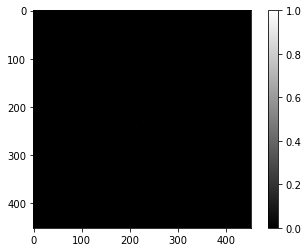

In [6]:
# Visualizing as sanity check
import matplotlib.pyplot as plt
from torchvision import transforms

# trans = transforms.Compose([transforms.ToTensor()])
demo_img = train_dataset[2][0]
# demo_img = trans(demo)
# print(demo_img.shape)
demo_array = np.moveaxis(demo_img.numpy()*255, 0, -1)
demo_img = torch.from_numpy(demo_array)
# print(demo_img.shape)


plt.figure()
plt.imshow(demo_img, cmap='gray')
plt.colorbar()
plt.show()

In [7]:
def check_accuracy(dataset, model):
    loader = DataLoader(dataset, batch_size=64, shuffle=True)
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [8]:
def train(model, optimizer, dataset, collate_fn, epochs=1):
    """
    Train a model PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print(f'Beginning epoch {e + 1}')
        loss = None
        model.train()  # put model to training mode
        data_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4, collate_fn=collate_fn)
#         counter = 0
        for imgs, targets in data_loader:
            
            for i in range(len(targets)):
                # print(len(targets[i]['boxes']) == len(targets[i]['labels']))
#                 print('boxes ', targets[i]['boxes'].shape)
#                 print('labels ', targets[i]['labels'].shape)
#                 print('image_id ', targets[i]['image_id'].shape)
#                 print('area ', targets[i]['area'].shape)
#                 print('iscrowd ', targets[i]['iscrowd'].shape)
                print('labels', targets[i]['labels'])
                targets[i]['boxes'] = targets[i]['boxes'].to(device=device)
                targets[i]['labels'] = targets[i]['labels'].to(device=device)
                targets[i]['image_id'] = targets[i]['image_id'].to(device=device)
                targets[i]['area'] = targets[i]['area'].to(device=device)
                targets[i]['iscrowd'] = targets[i]['iscrowd'].to(device=device)
            imgs = imgs.to(device)
#             print(imgs.device)
#             print(targets[0]['boxes'].device)
            images = list(image for image in imgs)
            targets = [{k: v for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
#             counter += 1
#             if counter == 10:
#                 break
        print(f"Finished epoch (Loss: {loss})")

In [9]:
def collate_fn(batch):
    """
    Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).

    :param batch: an iterable of N sets from __getitem__()
    :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
    """

    images = list()
    targets=list()

    for i, t in batch:
        images.append(i)
        targets.append(t)
    images = torch.stack(images, dim=0)

    return images, targets

In [10]:
# DEFINE THE PRETRAINED MODEL

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has num_classes which is user-defined
num_classes = 2  # 1 class (planet) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [11]:
learning_rate = 1e-3

#optimizer = optim.SGD(model.parameters(), lr=learning_rate, nesterov=True, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
train(model, optimizer, train_dataset, collate_fn, epochs=1)

Beginning epoch 1
labels tensor([ 1,  1, -1])
labels tensor([ 1,  1, -1])


RuntimeError: CUDA error: device-side assert triggered

In [ ]:
check_accuracy(test_dataset, model)

In [ ]:
check_accuracy(train_dataset, model)